In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Der Download der Daten.

train_img = pd.read_csv('../input/digit-recognizer/train.csv')
test_img = pd.read_csv('../input/digit-recognizer/test.csv')

In [4]:
# Eine kleine Aussicht der Daten.

train_img.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


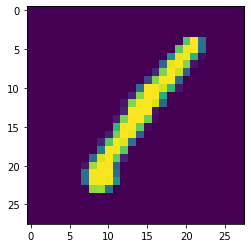

In [6]:
# Wie sehen die Bilder aus?

plt.imshow(train_img.drop(columns='label').iloc[0,:].values.reshape(28,28))

In [7]:
# Gibt es vielfältigen Daten??

train_img.duplicated().any()

False

In [8]:
# Die Verwendung Sklearn, um die Daten zu teilen: Trainingdaten und Validierungsdaten.

from sklearn.model_selection import train_test_split

train_lbl = train_img['label']
train_img = train_img.drop(columns = 'label')


train_img, val_img, train_lbl, val_lbl = train_test_split(train_img, train_lbl, test_size=0.20)

In [9]:
print(train_img.shape)
print(val_img.shape)

(33600, 784)
(8400, 784)


In [10]:
# Hier baue ich das Convnet-NN, und viele Erklärungen kommen davon...

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1))) # Jedes Bild hat 28x28-Dimensionen und einen Kanal. Deshalb gibt es 3-Dimensionen.
                                                                              # Die Nummer 32 (und in späteren Conv2D-Schichten, 64) bestimmt die dritte Dimension: der Kanal.
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))

from tensorflow.python.keras.callbacks import TensorBoard
from time import time

# Nach den Covnet-Schichten kommt eine Schichte voll mit dichte Neuronen...

model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) # Das Hinzufügen einer Dropoutschicht, womit 50% der Neuronen ausgeschaltet werden.
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))) # 64 Neuronen mit L2-Regularizierung.
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.001))) # Die Entscheidung von 10-Klassen, auch mit Regularizierung.

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

2022-05-02 19:54:30.945674: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 19:54:31.049682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 19:54:31.050421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 19:54:31.051816: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
# Eine Zussamenfassung des Models.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dropout (Dropout)            (None, 576)               0

In [12]:
# Die Vorverarbeitung des Training- und Validierungsatzes.

train_img = train_img.astype('float32')/255.0
val_img = val_img.astype('float32')/255.0

train_lbl = to_categorical(train_lbl)
val_lbl = to_categorical(val_lbl)

In [13]:
train_img = train_img.values.reshape((train_img.shape[0], 28, 28, 1))
val_img = val_img.values.reshape((val_img.shape[0], 28, 28, 1))

In [14]:
!dir

__notebook__.ipynb


In [15]:
# Die Passform des Models zu den Daten.

history = model.fit(
    train_img,
    train_lbl,
    epochs=50,
    batch_size=32,
    callbacks=[TensorBoard(log_dir = 'logs/{}'.format(time()))],
    validation_data=(val_img,val_lbl)
)

2022-05-02 19:54:34.360465: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-02 19:54:34.360517: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-05-02 19:54:34.364012: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-05-02 19:54:34.571424: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-05-02 19:54:34.571608: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-05-02 19:54:35.040853: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-05-02 19:54:36.395923: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


   1/1050 [..............................] - ETA: 1:58:04 - loss: 3.5022 - accuracy: 0.0938

2022-05-02 19:54:41.866368: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-02 19:54:41.866411: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/1050 [..............................] - ETA: 5:19 - loss: 3.4666 - accuracy: 0.1406   

2022-05-02 19:54:42.159488: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-05-02 19:54:42.160263: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-05-02 19:54:42.304413: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 141 callback api events and 138 activity events. 
2022-05-02 19:54:42.315795: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-05-02 19:54:42.333149: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/1651521274.3517299/train/plugins/profile/2022_05_02_19_54_42

2022-05-02 19:54:42.340230: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/1651521274.3517299/train/plugins/profile/2022_05_02_19_54_42/c33acbd13784.trace.json.gz


  37/1050 [>.............................] - ETA: 19s - loss: 2.9915 - accuracy: 0.2171

2022-05-02 19:54:42.367686: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/1651521274.3517299/train/plugins/profile/2022_05_02_19_54_42

2022-05-02 19:54:42.369927: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/1651521274.3517299/train/plugins/profile/2022_05_02_19_54_42/c33acbd13784.memory_profile.json.gz
2022-05-02 19:54:42.370980: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/1651521274.3517299/train/plugins/profile/2022_05_02_19_54_42
Dumped tool data for xplane.pb to logs/1651521274.3517299/train/plugins/profile/2022_05_02_19_54_42/c33acbd13784.xplane.pb
Dumped tool data for overview_page.pb to logs/1651521274.3517299/train/plugins/profile/2022_05_02_19_54_42/c33acbd13784.overview_page.pb
Dumped tool data for input_pipeline.pb to logs/1651521274.3517299/train/plugins/profile/2022_05_02_19_54_42/c33acbd13784.input_pipeline.pb
Dumped 

1050/1050 [==============================] - 12s 5ms/step - loss: 0.6999 - accuracy: 0.8522 - val_loss: 0.2468 - val_accuracy: 0.9707
Epoch 2/50
1050/1050 [==============================] - 4s 4ms/step - loss: 0.3155 - accuracy: 0.9472 - val_loss: 0.2023 - val_accuracy: 0.9773
Epoch 3/50
1050/1050 [==============================] - 4s 4ms/step - loss: 0.2692 - accuracy: 0.9571 - val_loss: 0.1839 - val_accuracy: 0.9824
Epoch 4/50
1050/1050 [==============================] - 4s 4ms/step - loss: 0.2430 - accuracy: 0.9643 - val_loss: 0.1717 - val_accuracy: 0.9832
Epoch 5/50
1050/1050 [==============================] - 4s 4ms/step - loss: 0.2306 - accuracy: 0.9660 - val_loss: 0.1679 - val_accuracy: 0.9812
Epoch 6/50
1050/1050 [==============================] - 4s 4ms/step - loss: 0.2134 - accuracy: 0.9692 - val_loss: 0.1464 - val_accuracy: 0.9870
Epoch 7/50
1050/1050 [==============================] - 4s 4ms/step - loss: 0.2019 - accuracy: 0.9714 - val_loss: 0.1673 - val_accuracy: 0.9814
Ep

In [16]:
# Welche sind die Schlüssel des Models?

history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [17]:
# Eine Funktion womit ich die Genauigkeit und den Verlust gerechnet und gemalt werden.

def acc_loss(var='accuracy'):
    mval = history.history[var]
    mval_var = history.history[f'val_{var}']
    epochs = range(1, len(mval)+1)

    plt.clf()
    plt.plot(epochs, mval, 'bo', label=f'mTraining {var}')
    plt.plot(epochs, mval_var, 'b', label=f'mValidation {var}')
    plt.title(f'Multiclass Training and Validation {var}')
    plt.xlabel('Epochs')
    plt.ylabel(f'{var}')
    plt.legend()

    plt.show()

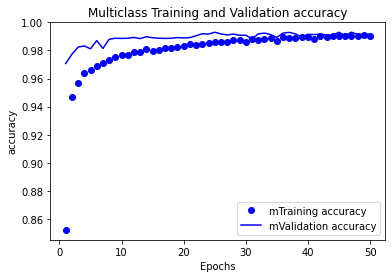

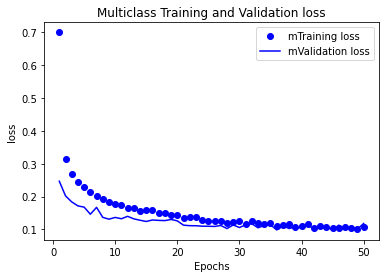

(None, None)

In [18]:
acc_loss(), acc_loss('loss')

In [19]:
# Die Vorverarbeitung der Prüfungsdaten.

test_img_reshape = test_img.values.reshape((test_img.shape[0], 28, 28, 1)) / 255.0

pred = model.predict(test_img_reshape)

In [20]:
# Wie ich die Ergibnisse herausfinde und danach in einer Liste sparre.

pred_list = []
for cell in pred:
    pred_list.append(list(cell).index(cell.max()))
    
pred_list[:10]

[2, 0, 9, 9, 3, 7, 0, 3, 0, 3]

In [21]:
pred_df = pd.DataFrame({'ImageId':test_img.index+1, 'Label':pred_list})
pred_df = pred_df.astype(str)
pred_df[pred_df['ImageId']=='27999']

,ImageId,Label
27998,27999,9


In [22]:
test_img

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
%load_ext tensorboard
%tensorboard --logdir logs

In [24]:
# Das Endergebnis.

pred_df.to_csv('digit_recognizer.csv', index=False)